# News Title Classification Project - Modeling (LSTM / GRU)

After I finished cleaning data, i realized:

* News Title length is not too long (mean character length: 53, max character length: 87)
* We have a small dataset (only 64654 rows)
* All Title length are written in English (one language)
* We have class imbalance problem!

## Evaluation Metrics - Macro F1-score

Because of class imbalance problem, also after [read this article](https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report), i choosed **Macro F1-score** for our evaluation metrics.

So i will use the model which has the highest Macro (avg) F1-score for production.

    Macro F1 calculates the F1 separated by class but not using weights for the aggregation, which resuls in a bigger penalisation when your model does not perform well with the minority classes (which is exactly what you want when there is class imbalance problem)
    
<hr>

## Model (Infrastructure) planning:

Nowadays, Transformer model like BERT, ALBERT, XLM-RoBERTa has proven to be especially effective for common natural language processing tasks. This model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.

I've read Transformer model can handle EXTREME long memory (LSTM / GRU only handle LONG memory). But i realized we only have small dataset here (different with real-working problem i believe), also only have 87 max character length.

    So i decided to start from LSTM / GRU model with fast-text word embedding, then compare with Transformer model like BERT, ALBERT etc

# Experiment with LSTM / GRU results:

|**Model**|**Bidirectional**|**Optimizer**|**Best Epoch**|**Val loss**|**Val Precision**|**Val Recall**|**F1 score (macro)**|**NOTES**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|2 LSTM (128, dropout=0.25), SpatialDropout1D(0.2)| No| Adam (default)| 11| 0.2005| 0.938| 0.926| 0.93| Baseline|
|2 GRU (128, dropout=0.25), SpatialDropout1D(0.2)| No| Adam (default)| 10| 0.2015| 0.9403| 0.9277| 0.92| Train-time Faster|
|2 GRU (128, dropout=0.5), SpatialDropout1D(0.2)| Yes| Adam (default)| 9| 0.2064| 0.9392| 0.9268| 0.92| Train-time longer, no improvement|
|2 GRU (128, dropout=0.5), SpatialDropout1D(0.2) with class balanced| Yes| Adam (default)| 9| 0.2137| 0.9331| 0.9201| 0.92| Best BALANCED Recall for all label|
|Same above, add Synonym Text Augmentation| Yes| Adam (default)| 11| 0.1710| 0.9464| 0.9355| 0.93| Best validation performance, 2 hours Train-time|
|Same above, add Synonym Text Augmentation + Label Smoothing| Yes| Adam (default)| 11| 0.4686 (label smoothing)| 0.9468| 0.9322| 0.93| Better generalization with label smoothing|

## Conclusion

* Our LSTM / GRU perform well for this classification task.
* Actually we can got better performance with bigger dataset, add self-attention, etc.
* The big problem is on **Technology and Business category news-title**, because of these title tend to have a multi-labeled category problem, it was difficult to got a high recall for these two category

<hr>

    Next i will try TRANSFORMER model like BERT, ALBERT etc, i believe we can get better performance with these model, let's see on my next notebook :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import random
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', None)

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.3.0


In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(2020)

In [3]:
news_df_cleaned = pd.read_csv('/kaggle/input/gtect-project/news_title_cleaned.csv')

print('News df cleaned shape:', news_df_cleaned.shape)

News df cleaned shape: (64654, 3)


In [4]:
news_df_cleaned.head()

,News Title,Category,text_length
0,google rolls out stories for tricked out photo playback,Technology,55
1,dov charney s redeeming quality,Business,31
2,white god adds un certain regard to the palm dog,Entertainment,48
3,google shows off androids for wearables cars tvs,Technology,48
4,china may bank loans at bln yuan,Business,36


In [5]:
# https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma

weight_for_Technology = (1 / len(news_df_cleaned[news_df_cleaned['Category'] == 'Technology'])) * (news_df_cleaned.shape[0]) / 4.0
weight_for_Business = (1 / len(news_df_cleaned[news_df_cleaned['Category'] == 'Business'])) * (news_df_cleaned.shape[0]) / 4.0
weight_for_Entertainment = (1 / len(news_df_cleaned[news_df_cleaned['Category'] == 'Entertainment'])) * (news_df_cleaned.shape[0]) / 4.0
weight_for_Medical = (1 / len(news_df_cleaned[news_df_cleaned['Category'] == 'Medical'])) * (news_df_cleaned.shape[0]) / 4.0

# set balanced class-weights
class_weight = {0: weight_for_Technology,
                1: weight_for_Business,
                2: weight_for_Entertainment,
                3: weight_for_Medical}

print('Weight for class 0 (Technology): {:.2f}'.format(weight_for_Technology))
print('Weight for class 1 (Business): {:.2f}'.format(weight_for_Business))
print('Weight for class 2 (Entertainment): {:.2f}'.format(weight_for_Entertainment))
print('Weight for class 3 (Medical): {:.2f}'.format(weight_for_Medical))

Weight for class 0 (Technology): 0.97
Weight for class 1 (Business): 0.93
Weight for class 2 (Entertainment): 0.68
Weight for class 3 (Medical): 2.31


In [6]:
# convert label to label-encoder
cat2id = {
    'Technology': 0,
    'Business': 1,
    'Entertainment': 2,
    'Medical': 3
}

# convert back label-encoder to original label (after prediction)
id2cat = {
    0: 'Technology',
    1: 'Business',
    2: 'Entertainment',
    3: 'Medical'
}

In [7]:
news_df_cleaned['Category'] = news_df_cleaned['Category'].map(cat2id)

## Validation Strategy

* First, i divided train_dataset 90% - test_dataset 10%

GOAL: Use test dataset TO MEASURE our model performance quality AFTER training

<hr>

* Then i divided train_dataset 90% - validation_dataset 10%

GOAL: Use validation dataset TO MEASUE our model performance DURING training

In [8]:
from sklearn.model_selection import train_test_split

# train_dataset 90% - test_dataset 10%
X_train, X_test, y_train, y_test = train_test_split(news_df_cleaned['News Title'],
                                                   news_df_cleaned['Category'],
                                                   test_size=0.1,
                                                   stratify=news_df_cleaned['Category'],
                                                   random_state=2020)

# Usually more data we have, better performance we can achieve in Deep Learning

Deep Learning models typically have millions of parameters, thus require large amounts of data for training in order for over-fit avoidance and better model generalization. However, collecting a large annotated data samples is time-consuming and expensive. One technique aiming to address such a data hungry problem is data augmentation.

Proper data augmentation is useful to boost up your model performance. Augmentation is very popular in computer vision area. Image can be augmented easily by flipping, rotation, random cropping etc. It is proved that augmentation is one of the anchor to success of computer vision model.

In Natural Language Processing field, it is hard to augmenting text due to high complexity of language. Not every word we can replace it by others such as a, an, the. Also, not every word has synonym. Even changing a word, the context will be totally difference.

There are several techniques to do **text augmentation**:
* Synonym Replacement: Randomly replace n words in the sentences with their synonyms
* Random Insertion: Insert random synonyms of words in a sentence, this is done n times
* Random Deletion: Random removal for each word in the sentence with a probability p
* Contextualized Word Embeddings
* Text Generation (GPT-2 or XLNet)

> For reference please [check here](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28). In this notebook we'll use [nlpaug](https://pypi.org/project/nlpaug/) library

    Actually web scraping or finding similar dataset also effective, but i tried to use this technique in this project

In [9]:
!pip install nlpaug -q

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [10]:
%%time

review_augmented = []

# aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2') # Text Generation
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.5) # higher aug_p = substitute more words

for news_title in tqdm(X_train):
    augmented_text = aug.augment(news_title)
    review_augmented.append(augmented_text)


CPU times: user 1min 18s, sys: 1.85 s, total: 1min 20s
Wall time: 1min 22s


In [11]:
train_aug = pd.DataFrame({'News Title': review_augmented,
                          'Category': y_train})

original_train = pd.DataFrame({'News Title': X_train,
                               'Category': y_train})

new_train = pd.concat([train_aug, original_train])

print('Original shape:', original_train.shape)
print('Augmented shape:', train_aug.shape)
print('new train (combined) shape:', new_train.shape)

Original shape: (58188, 2)
Augmented shape: (58188, 2)
new train (combined) shape: (116376, 2)


In [12]:
#  train_dataset 90% - validation_dataset 10%
X_train, X_valid, y_train, y_valid = train_test_split(new_train['News Title'],
                                                      new_train['Category'],
                                                      test_size=0.1,
                                                      stratify=new_train['Category'],
                                                      random_state=2020)

print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (104738,)
X_valid shape: (11638,)
X_test shape: (6466,)


In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

# fit to train
tokenizer.fit_on_texts(X_train)

# then convert text to numpy array
train_sequences = tokenizer.texts_to_sequences(X_train)
valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences = tokenizer.texts_to_sequences(X_test)

# count number of vocabulary in dataset
vocab_size = len(tokenizer.word_index)
print('Vocabulary size:', vocab_size)

Vocabulary size: 32633


In [17]:
# save tokenizer for deployment later
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

# load for prediction (use for deployment later)
# tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAXLEN = max(map(len, new_train['News Title'].str.split()))
print('max_len:', MAXLEN)

# padding='post' -> make sure all sentences are the same length, by add ZERO PADDING to sentences whose less than max_len
# truncating='post' -> cut text that exceeds the limit of max_len, post mean cut at the back of the sentence
X_train_padded = pad_sequences(train_sequences, maxlen=MAXLEN, padding='post', truncating='post')
X_valid_padded = pad_sequences(valid_sequences, maxlen=MAXLEN, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAXLEN, padding='post', truncating='post')

max_len: 26


### Example: before - after padding

In [27]:
print('Before Padding:\n')
print(train_sequences[10])

print('')

print('After Padding:\n')
print(X_train_padded[10])

Before Padding:

[1439, 625, 1, 12852, 5137, 9835, 152, 108, 17810, 8, 402, 2536]

After Padding:

[ 1439   625     1 12852  5137  9835   152   108 17810     8   402  2536
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Use Fast-Text word embedding

One major draw-back for **another** word-embedding techniques like **word2vec** and **glove** was its inability to deal with out of corpus words. If there is a word that does not appear in the corpus, word2vec or glove fails to get their vectorized representation.

Fasttext treats each word as composed of n-grams. That is let us say value of n is 3 for the word ‘India’ we have ‘<in’, ‘ind’, ‘ndi’, ‘di>’ as the n-gram representation. That's why Fasttext can generate embedding for the words that does not appear in the training corpus. This can be done by adding the character n-gram of all the n-gram representations.

In [28]:
def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [29]:
FASTTEXT_PATH = '../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl'

fasttext_matrix, unknown_word_fasttext = build_matrix(tokenizer.word_index, FASTTEXT_PATH)
print('Unknown words in fasttext:', len(unknown_word_fasttext))

Unknown words in fasttext: 2388


### What is unknown word?

    a list of words which fasttext fails to get their vector representation

In [30]:
unknown_word_fasttext[:10]

['beyonc',
 'labeouf',
 'alstom',
 'dorfman',
 'oxycantha',
 'paribas',
 'leontyne',
 'hortons',
 "one's",
 'shailene']

## Create LSTM / GRU model

### Add Label Smoothing

When using deep learning models for classification tasks, we usually encounter the following problems: overfitting, and overconfidence. Overfitting is well studied and can be tackled with early stopping, dropout, weight regularization etc. On the other hand, we have less tools to tackle overconfidence. Label smoothing is a regularization technique that addresses both problems.

    label smoothing has been used in many state-of-the-art models, including image classification, language translation and speech recognition

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense, GRU, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

def get_model():
    
    embedding = Embedding(vocab_size+1, 300, weights=[fasttext_matrix], trainable=False, input_length=MAXLEN)
    
    model = Sequential()
    model.add(embedding)
    model.add(SpatialDropout1D(0.2))
    
    # add BIDIRECTIONAL
    model.add(Bidirectional(GRU(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5)))
    
    model.add(Dense(4, activation='softmax')) # 4 class label to classify
    
    # compile model
    model.compile(optimizer='adam',
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    
    return model

In [34]:
K.clear_session()

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 300)           9790200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 26, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 256)           330240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 10,417,916
Trainable params: 627,716
Non-trainable params: 9,790,200
_________________________________________________________________


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='best_GRU_loss.h5')

In [36]:
BATCH_SIZE = 64
n_steps = X_train.shape[0] // BATCH_SIZE

history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=n_steps,
                    epochs=12,
                    validation_data=(X_valid_padded, y_valid),
                    callbacks=[checkpoint],
                    class_weight=class_weight)

Epoch 1/12
1636/1636 [==============================] - 626s 382ms/step - loss: 0.6926 - precision: 0.8732 - recall: 0.7707 - val_loss: 0.5954 - val_precision: 0.8987 - val_recall: 0.8440
Epoch 2/12
1636/1636 [==============================] - 608s 371ms/step - loss: 0.6107 - precision: 0.8963 - recall: 0.8349 - val_loss: 0.5507 - val_precision: 0.9179 - val_recall: 0.8754
Epoch 3/12
1636/1636 [==============================] - 606s 370ms/step - loss: 0.5745 - precision: 0.9105 - recall: 0.8599 - val_loss: 0.5362 - val_precision: 0.9206 - val_recall: 0.8894
Epoch 4/12
1636/1636 [==============================] - 606s 370ms/step - loss: 0.5480 - precision: 0.9206 - recall: 0.8768 - val_loss: 0.5160 - val_precision: 0.9292 - val_recall: 0.9035
Epoch 5/12
1636/1636 [==============================] - 607s 371ms/step - loss: 0.5304 - precision: 0.9262 - recall: 0.8890 - val_loss: 0.5102 - val_precision: 0.9315 - val_recall: 0.9062
Epoch 6/12
1636/1636 [==============================] - 608s

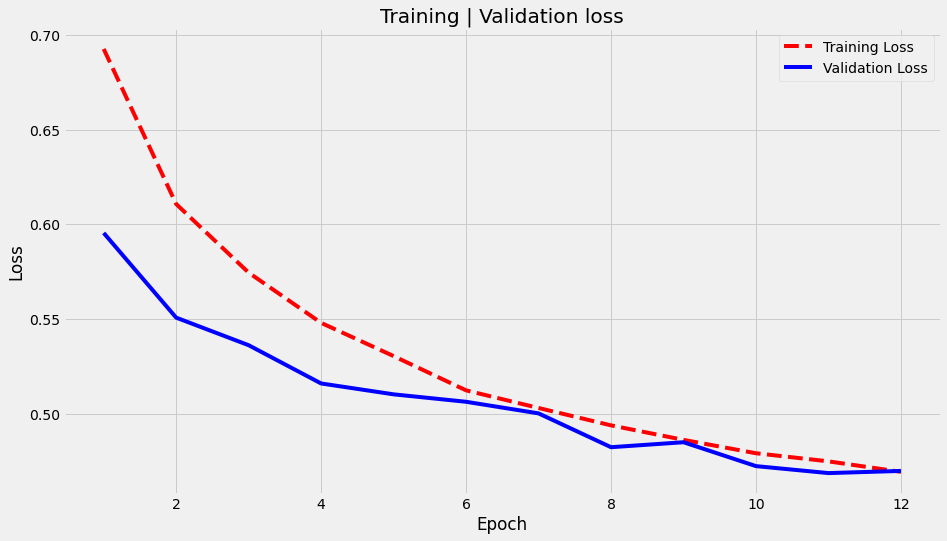

In [37]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training | Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [38]:
from tensorflow.keras.models import load_model

best_model = load_model('../working/best_GRU_loss.h5')

In [39]:
## predict utk dapet hasil asli-nya
y_pred = best_model.predict(X_test_padded, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

203/203 [==============================] - 6s 29ms/step


In [40]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1658
           1       0.92      0.91      0.91      1745
           2       0.97      0.96      0.96      2363
           3       0.91      0.94      0.92       700

    accuracy                           0.93      6466
   macro avg       0.93      0.93      0.93      6466
weighted avg       0.93      0.93      0.93      6466



In [41]:
id2cat = {
    0: 'Technology',
    1: 'Business',
    2: 'Entertainment',
    3: 'Medical'
}

y_pred_decoded = pd.Series(y_pred).map(id2cat)

In [42]:
pd.DataFrame({'News Title': X_test.reset_index(drop=True),
              'Category': y_pred_decoded}).sample(10)

,News Title,Category
96,beyonce getting love advice from gwyneth paltrow,Entertainment
2608,rewalk exoskeleton for paraplegics gets fda approval,Medical
3686,beyonc is named one of time s most influential people,Entertainment
4130,sovaldi a pill for hepatitis c cures the liver wasting disease but it is costly,Medical
3393,earth like planets gliese g and d likely do not exist study,Technology
4808,record store day coming to a uk independent record shop near you,Entertainment
5383,casino developer applications flood york state offices,Business
4994,free ice cream today,Entertainment
3234,garth brooks court application to stop all concerts to be heard on thursday,Entertainment
2050,facebook to use drones lasers satellites to bring internet everywhere,Technology


## References:

* [Understanding FastText:An Embedding To Look Forward To](https://medium.com/@adityamohanty/understanding-fasttext-an-embedding-to-look-forward-to-3ee9aa08787)
* [Multi-Class Metrics Made Simple, Part II: the F1-score](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)
* [A Tale of Two Macro-F1's](https://towardsdatascience.com/a-tale-of-two-macro-f1s-8811ddcf8f04)
* [When Does Label Smoothing Help?](https://arxiv.org/pdf/1906.02629.pdf)